## Imports

In [ ]:
%load_ext lab_black

import h5py
import os
import numpy as np
from typing import Dict, List, Optional, Tuple

from dataclasses import dataclass
from tqdm.auto import tqdm
from scipy.signal import savgol_filter
from scipy.interpolate import interp2d
from functools import lru_cache
import lmfit as lm


import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt


import sys

sys.path.append(r"C:\Users\atully\Code\GitHub\ARPES Code\arpes-code-python")
from arpes_functions import (
    fitting_functions,
    analysis_functions,
    plotting_functions,
    HDF5_loader,
    misc_functions,
    filter_functions,
    tr_functions,
    loading_functions,
    kw_data_loader,
    cnn,
)

colors = pc.qualitative.D3
colors_seq = pc.sequential.dense
angstrom = "\u212B"
Theta = "\u0398"

# Load Data

# HS Cuts

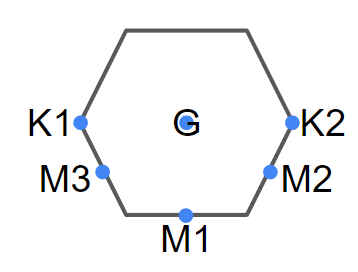

In [ ]:
xaxis_title = f"k<sub>x</sub> ({angstrom}<sup>-1</sup>)"
yaxis_title = f"E - E<sub>HOMO</sub> (eV)"

In [ ]:
ddir = r"E:\atully\arpes_data\2023_June\C60\ARPES\Imgs\k_corrected"

In [ ]:
## Gamma, CT1 ##
g_ct1_data, g_ct1_theta, g_ct1_energy = HDF5_loader.load_hdf5(ddir, "G_CT1_g_kw.h5")

In [ ]:
## Gamma, CT2 ##
g_ct2_data, g_ct2_theta, g_ct2_energy = HDF5_loader.load_hdf5(ddir, "G_CT2_g_kw.h5")

# Set Up Data

In [ ]:
## HOMO is at 2.05 eV below EF, based on fits from this data averaged with fits from tr-ARPES results ##

EF_400 = 1.91  # in kinetic energy, slit 400
EF_700 = 1.94  # in kinetic energy, slit 700

homo = -2.05

homo_400 = homo + EF_400

In [ ]:
## Adjust energy axis to be relative to HOMO ##
homo_zero = False
homo_zero = True

if homo_zero:
    g_ct1_energy = g_ct1_energy - homo_400
    g_ct2_energy = g_ct2_energy - homo_400

In [ ]:
## Limit Dataset and FFT ##

data, x, y = g_ct2_data, g_ct2_theta, g_ct2_energy

xlim = None
ylim = None
# ylim = (energy[57], energy[1007])  # get rid of zero padding on datasets
# ylim = (2.07, 2.42)
xlim = (-0.2, 0.17)

f_data = filter_functions.fft2d_mask(data, plot=False)

x_plot, y_plot, data_plot = analysis_functions.limit_dataset(
    x,
    y,
    f_data,
    xlim=xlim,
    ylim=ylim,
)

# d_avg = analysis_functions.norm_data(d_avg)

In [ ]:
## Plot ##

# x_plot, y_plot, data_plot = g_ct1_theta, g_ct1_energy, g_ct1_data
x_plot, y_plot, data_plot = x_plot, y_plot, data_plot

fig = tr_functions.thesis_fig(
    title="G CT1",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
    height=600,
    width=600,
)

fig.add_trace(
    go.Heatmap(
        x=x_plot,  # fix incorrect traces by, first, plotting without x-axis
        y=y_plot,  # fix incorrect traces by, first, plotting without y-axis
        # z=data_plot,
        z=analysis_functions.norm_data(data_plot),
        coloraxis="coloraxis",
    )
)

fig.update_coloraxes(cmin=0, cmax=0.22)

fig.show()

In [ ]:
## Get and Plot 1D Data --> EDC ##
xlim = (3, 7)
xlim = None
ylim = None

fig = tr_functions.thesis_fig(
    title=f"EDC",
    xaxis_title="Intensity (arb. u)",
    yaxis_title=yaxis_title,
    equiv_axes=False,
    gridlines=False,
    height=1000,
    width=600,
    # height=800,
    # width=500,
)

y_1d, col = tr_functions.get_1d_x_slice(
    x=x_plot, y=y_plot, data=data_plot, ylims=ylim, x_range=xlim
)

# fig.add_trace(go.Scatter(x=y_1d, y=col, line=dict(color=colors[0])))
fig.add_trace(go.Scatter(x=col, y=y_1d, line=dict(color=colors[0])))

fig.show()

## Get and Plot 1D Data --> MDC ##
xlim = None
# ylim = (2.15, 2.25)
ylim = None

fig = tr_functions.thesis_fig(
    title=f"MDC",
    xaxis_title=xaxis_title,
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    # height=600,
    # width=800,
)

x_1d, row = tr_functions.get_1d_y_slice(
    x=x_plot, y=y_plot, data=data_plot, xlims=xlim, y_range=ylim
)

fig.add_trace(go.Scatter(x=x_1d, y=row, line=dict(color=colors[0])))

fig.show()

# Stitch Datasets

In [ ]:
title = "CT1 & CT2 at G"

In [ ]:
data1, theta1, energy1 = g_ct1_data, g_ct1_theta, g_ct1_energy  # CT1
data2, theta2, energy2 = g_ct2_data, g_ct2_theta, g_ct2_energy  # CT2

In [ ]:
f_data1 = filter_functions.fft2d_mask(data1, plot=False)
f_data2 = filter_functions.fft2d_mask(data2, plot=False)

In [ ]:
## Stitch and Average Datasets ##

xlim = None
ylim = None

xlim = (-0.16, 0.16)
# xlim = (-0.17, 0.17)
ylim1 = (2.00, 2.5)  # 2.07, 2.5
ylim2 = (2.48, 3.15)

x1, y1, dataslice1 = analysis_functions.limit_dataset(
    theta1,
    energy1,
    f_data1,
    xlim=xlim,
    ylim=ylim1,
)

x2, y2, dataslice2 = analysis_functions.limit_dataset(
    theta2,
    energy2,
    f_data2,
    xlim=xlim,
    ylim=ylim2,
)

xs, ys, ds = tr_functions.stitch_and_avg(
    x1,
    y1,
    dataslice1,
    x2,
    y2,
    dataslice2,
    no_avg=True,
)

In [ ]:
## Plot Data ##
x, y, data = xs, ys, ds

fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
    height=600,
    width=500,
)

fig.add_trace(
    go.Heatmap(x=x, y=y, z=analysis_functions.norm_data(data), coloraxis="coloraxis")
)

fig.update_coloraxes(cmin=0.07, cmax=0.25)
fig.update_coloraxes(colorscale="Blues", reversescale=False)

fig.show()

In [ ]:
g_full_ct_x, g_full_ct_y, g_full_ct_data = xs, ys, ds

In [ ]:
## Get and Plot 1D Data --> EDC ##
# ylim = (2.1, 2.8)
ylim = (2.0, 2.8)
xlim = None
ylim = None
ylim = (2.0, 3.0)

x_plot, y_plot, data_plot = g_full_ct_x, g_full_ct_y, g_full_ct_data

fig = tr_functions.thesis_fig(
    title=f"EDC",
    xaxis_title="Intensity (arb. u)",
    yaxis_title=yaxis_title,
    equiv_axes=False,
    gridlines=False,
    height=1000,
    width=600,
    # height=800,
    # width=500,
)

y_1d, col = tr_functions.get_1d_x_slice(
    x=x_plot, y=y_plot, data=data_plot, ylims=ylim, x_range=xlim
)

# fig.add_trace(go.Scatter(x=y_1d, y=col, line=dict(color=colors[0])))
fig.add_trace(go.Scatter(x=col, y=y_1d, line=dict(color=colors[0])))

fig.show()

# ## Get and Plot 1D Data --> MDC ##
# xlim = None
# ylim = (2.15, 2.25)
# ylim = None

# fig = tr_functions.thesis_fig(
#     title=f"MDC",
#     xaxis_title=xaxis_title,
#     yaxis_title="Intensity (arb. u)",
#     equiv_axes=False,
#     gridlines=False,
#     # height=600,
#     # width=800,
# )

# x_1d, row = tr_functions.get_1d_y_slice(
#     x=x_plot, y=y_plot, data=data_plot, xlims=xlim, y_range=ylim
# )

# fig.add_trace(go.Scatter(x=x_1d, y=row, line=dict(color=colors[0])))

# fig.show()

In [ ]:
x = y_1d
data = col

offset_type = "constant"
plot_fit = True


## Offset
c = np.mean(data)
b = (data[-1] - data[0]) / (x[-1] - x[0])
a = 0

offset = fitting_functions.offset_model(offset_type, a, b, c)


## FD
def fermi_dirac(x, center, theta, amp):
    arg = (x - center) / (2 * theta)  # x=E, center=mu, theta = k_B * T
    return -amp / 2 * np.tanh(arg)


## Gaussians
gauss1 = fitting_functions.make_gaussian(num="A_", amplitude=1, center=2.2, sigma=0.1)
gauss2 = fitting_functions.make_gaussian(num="B_", amplitude=1, center=2.55, sigma=0.1)
gauss3 = fitting_functions.make_gaussian(num="C_", amplitude=1, center=2.8, sigma=0.1)
# gauss4 = fitting_functions.make_gaussian(num="D_", amplitude=1, center=2.9, sigma=0.1)


## Full model
full_model = lm.models.Model(fermi_dirac) + gauss1 + gauss2 + gauss3 + offset
# full_model = lm.models.Model(fermi_dirac) + gauss1 + gauss2 + gauss3 + gauss4 + offset

# full_model = gauss1 + gauss2 + gauss3 + offset

# full_model = lm.models.Model(fermi_dirac) + offset

params = full_model.make_params()

params["center"].value = 2.0325  # Based on TR data
# params["center"].vary = False
T = 10.6  # measurement temp
k_B = 8.617333e-5  # eV/K

## initial params
# params["theta"].value = k_B * (10.6)
# params["theta"].min = 0
# params["amp"].value = 1
# params["amp"].min = 0

## final params
params["theta"].value = 0.02027560
# params["theta"].vary = False
params["amp"].value = 173.920569
# params["amp"].vary = False
params["c"].value = 132.268557
# params["c"].vary = False

params["iA__center"].min = 2.0
params["iA__center"].max = 2.3
params["iB__center"].min = 2.3
params["iB__center"].max = 2.8
params["iC__center"].min = 2.6
params["iC__center"].max = 3.0
# params["iD__center"].min = 2.6
# params["iD__center"].max = 3.0

params["iA__fwhm"].max = 0.5
params["iB__fwhm"].max = 0.5
params["iC__fwhm"].max = 0.5
# params["iD__fwhm"].max = 0.5


fit = full_model.fit(data, x=x, params=params)
if plot_fit:
    fit.plot()

print(f"Center A = {fit.params['iA__center'].value:.2f} eV")
print(f"FWHM A = {fit.params['iA__fwhm'].value:.3f} eV")
print(f"Center B = {fit.params['iB__center'].value:.2f} eV")
print(f"FWHM B = {fit.params['iB__fwhm'].value:.3f} eV")
print(f"Center C = {fit.params['iC__center'].value:.2f} eV")
print(f"FWHM C = {fit.params['iC__fwhm'].value:.3f} eV")
# print(f"Center D = {fit.params['iD__center'].value:.2f} eV")
# print(f"FWHM D = {fit.params['iD__fwhm'].value:.3f} eV")

In [ ]:
fit.result

In [ ]:
## Plot Data and Fit
fig = tr_functions.thesis_fig(
    title=f"EDC",
    xaxis_title="Intensity (arb. u)",
    yaxis_title=yaxis_title,
    equiv_axes=False,
    gridlines=False,
    height=500,
    width=300,
    dtick_y=0.2
    # height=800,
    # width=500,
)

fig.add_trace(go.Scatter(x=col, y=y_1d, line=dict(color=colors[0]), name="data"))

fig.add_trace(go.Scatter(x=fit.eval(x=y_1d), y=y_1d, name="fit"))


components = fit.eval_components(x=y_1d)
for model_name, model_value in list(components.items())[1:4]:
    fig.add_annotation(
        x=fit.eval(x=fit.params[f"{model_name}center"].value),
        y=fit.params[f"{model_name}center"].value,
        text=f'{fit.params[f"{model_name}center"].value:.2f} ',
        font=dict(size=18, color=colors[0]),
        ax=50,
        ay=30,
        bgcolor="white",
        # opacity=1,
        # bordercolor=colors[0],
        # borderwidth=2,
        # borderpad=4,
    )

# fig.update_yaxes(range=(2.0, 2.8))

fig.show()

In [ ]:
## Plot Fit Components ##

fig = tr_functions.thesis_fig(
    title=f"{title}<br> Fit Components",
    xaxis_title=yaxis_title,
    yaxis_title="Intensity [arb. u]",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=900,
)

components = fit.eval_components(x=y_1d)
for model_name, model_value in components.items():
    fig.add_trace(
        go.Scatter(
            x=y_1d,
            y=model_value,
            name=model_name,
        )
    )

fig.data[4].update(name="offset")

for model_name, model_value in list(components.items())[1:4]:
    fig.add_annotation(
        x=fit.params[f"{model_name}center"].value,
        # y=fit.eval(x=fit.params[f"{model_name}center"].value),
        # xref="x domain",
        yref="y domain",
        # The arrow head will be 25% along the x axis, starting from the left
        # x=0.25,
        # The arrow head will be 40% along the y axis, starting from the bottom
        y=0.3,
        showarrow=False,
        text=f'{fit.params[f"{model_name}center"].value:.2f} eV<br>{fit.params[f"{model_name}fwhm"].value:.2f} eV',
        font=dict(size=12),
        # ax=-300,
        # ay=0,
        bgcolor="white",
        # opacity=1,
        # bordercolor=colors[0],
        # borderwidth=2,
        # borderpad=4,
    )


fig.show()